In [ ]:
import torch
from torch import nn
from torch.nn import Conv2d, Linear, Sequential, BatchNorm2d, ReLU, LeakyReLU, Sigmoid, Tanh, ConvTranspose2d, BatchNorm1d
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.transforms import Resize, Normalize, CenterCrop, ToTensor, Compose
from tqdm import tqdm

In [ ]:
a = torch.constabtkl

In [ ]:
# Define hyperparams
IMG_SIZE = (3, 64, 64)
BATCH_SIZE = 64
LATENT_SIZE = (100, 1, 1)
NUM_EPOCHS = 5
DATAROOT = "./data/celeba/"
NUM_WORKERS = 2
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ndf = 64
ngf = 64

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( LATENT_SIZE[0], ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, IMG_SIZE[0], 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(IMG_SIZE[0], ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
dataset = ImageFolder(root=DATAROOT, transform=Compose([
    Resize(IMG_SIZE[1:]),
    CenterCrop(IMG_SIZE[1:]),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
dataloader = DataLoader(dataset, BATCH_SIZE, True, num_workers=NUM_WORKERS)

In [ ]:
generator = Generator().apply(weights_init).to(DEVICE)
critic = Critic().apply(weights_init).to(DEVICE)
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(critic.parameters(), lr=0.0002, betas=(0.5, 0.999))

Grid shape:  torch.Size([3, 266, 266])


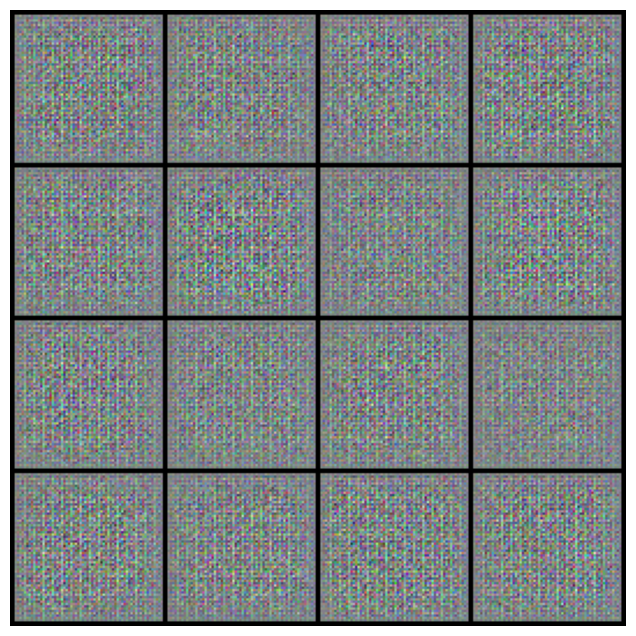

In [8]:
# Test Model
import numpy as np
import matplotlib.pyplot as plt
with torch.no_grad():
    noise = torch.randn((16, *LATENT_SIZE)).to(DEVICE)
    img_gen = generator(noise).cpu()
    grid = make_grid(img_gen, nrow=4, normalize=True)
    print("Grid shape: ", grid.shape)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid ,(1, 2, 0)))
    plt.axis("off")
    plt.show()


In [9]:
fixed_noise = torch.randn(16, *LATENT_SIZE).to(DEVICE)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")

2023-02-28 14:51:51.587290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [11]:
step = 0
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real_batch, _) in enumerate(tqdm(dataloader)):
        real_batch = real_batch.to(DEVICE)
        b_size = real_batch.size(0)

        for _ in range(5):
            noise = torch.rand(b_size, *LATENT_SIZE).to(DEVICE)
            img_gen = generator(noise)
            critic_real = critic(real_batch).reshape(-1)
            critic_fake = critic(img_gen).reshape(-1)
            gp = gradient_penalty(critic, real_batch, img_gen, DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + 10 * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            gen_opt.step()
        
        gen_fake = critic(img_gen).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        generator.zero_grad()
        loss_gen.backward()
        gen_opt.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = generator(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = make_grid(real_batch[:16], normalize=True, nrow=4)
                img_grid_fake = make_grid(fake[:16], normalize=True, nrow=4)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

  0%|          | 0/3166 [00:01<?, ?it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [64, 3, 4, 4]] is at version 6; expected version 5 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).